# Introducción a GIS con Python
## ¿Qué es GIS?
GIS significa _sistema de información geográfica_. Coloquialmente, es el proceso de presentar y analizar datos en mapas. El SIG nos permite visualizar y caracterizar la naturaleza de los datos distribuidos espacialmente, incluido el clima, la infraestructura y las poblaciones. Como puede imaginar, esto es clave para los escenarios de respuesta a desastres tanto para diagnosticar la situación como para planificar y monitorear la respuesta.

Hay docenas de diferentes opciones de software SIG, tanto gratuitas como comerciales. En este curso, nos centraremos en herramientas y paquetes gratuitos basados en Python. Los principios que se enseñan en este curso deben aplicarse a las implementaciones de SIG más comunes.

En particular, usaremos:
- GDAL
- geopandas

Este contenido se basa en el [curso Automatización de procesos GIS] (https://automating-gis-processes.github.io/2018/) de la Universidad de Helsinki.

In [1]:
!pip install geopandas
!pip install contextily
!pip install shapely
!pip install matplotlib

     |████████████████████████████████| 1.0 MB 15.9 MB/s 
     |████████████████████████████████| 15.4 MB 37.5 MB/s 
     |████████████████████████████████| 6.3 MB 55.7 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [2]:
import geopandas as gpd
import contextily as ctx # for basemaps
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt

##**Lectura en datos GIS**

Para esta lección, usamos datos en formato Shapefile que representan distribuciones de especies de peces de hermosos colores específicas llamadas Damiselas y las fronteras de los países de Europa.

Vamos a utilizar el comando de terminal `wget` para descargar un archivo desde una URL.
Luego usamos `unzip` para descomprimir el archivo en una carpeta con el mismo nombre. La opción `-o` se usa para sobrescribir la carpeta si ya existe
Luego usamos `ls` para ver el contenido de la carpeta

In [3]:
!wget https://github.com/Automating-GIS-processes/FEC/raw/master/data/DAMSELFISH.zip -O fish_data.zip
!unzip -o fish_data.zip -d fish_data
!ls fish_data

--2021-12-03 01:23:02--  https://github.com/Automating-GIS-processes/FEC/raw/master/data/DAMSELFISH.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Automating-GIS-processes/FEC/master/data/DAMSELFISH.zip [following]
--2021-12-03 01:23:02--  https://raw.githubusercontent.com/Automating-GIS-processes/FEC/master/data/DAMSELFISH.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12713865 (12M) [application/zip]
Saving to: ‘fish_data.zip’

fish_data.zip       100%[===================>]  12.12M  --.-KB/s    in 0.07s   

2021-12-03 01:23:03 (175 MB/s) - ‘fish_data.zip’ saved [12713865/12713865]

A

Normalmente, leer los datos en Python es el primer paso del proceso de análisis. En GIS, existen varios formatos de datos como
[Shapefile] (https://en.wikipedia.org/wiki/Shapefile), 
[GeoJSON] (https://en.wikipedia.org/wiki/GeoJSON), 
[KML] (https://en.wikipedia.org/wiki/Keyhole_Markup_Language) y 
[GPKG] (https://en.wikipedia.org/wiki/GeoPackage) que son probablemente los formatos de datos vectoriales más comunes. Geopandas es capaz de leer datos de todos estos formatos (y muchos más). La lectura de datos espaciales se puede hacer fácilmente con geopandas usando la función `gpd.read_file ()`:

In [4]:
# ruta al shapefile
filepath = "fish_data/DAMSELFISH_distributions.shp"

# Leer archivo usando gpd.read_file()
data = gpd.read_file(filepath)

In [5]:
data.head() #mire las entradas principales: parece un dataframe de pandas

,id_no,binomial,origin,compiler,year,citation,source,dist_comm,island,subspecies,subpop,legend,seasonal,tax_comm,rl_update,kingdom_na,phylum_nam,class_name,order_name,family_nam,genus_name,species_na,category,shape_Leng,shape_Area,ORIG_FID,geometry
0,183963.0,Stegastes leucorus,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,leucorus,VU,82.368856,28.239363,0,"POLYGON ((-115.64375 29.71392, -115.61585 29.6..."
1,183963.0,Stegastes leucorus,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,leucorus,VU,82.368856,28.239363,0,"POLYGON ((-105.58995 21.89340, -105.56483 21.8..."
2,183963.0,Stegastes leucorus,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,leucorus,VU,82.368856,28.239363,0,"POLYGON ((-111.15962 19.01536, -111.15948 18.9..."
3,183793.0,Chromis intercrusma,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,intercrusma,LC,729.012180,87.461539,1,"POLYGON ((-80.86500 -0.77894, -80.75930 -0.833..."
4,183793.0,Chromis intercrusma,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,intercrusma,LC,729.012180,87.461539,1,"POLYGON ((-67.33922 -55.67610, -67.33755 -55.6..."


In [6]:
data.columns

Index(['id_no', 'binomial', 'origin', 'compiler', 'year', 'citation', 'source',
       'dist_comm', 'island', 'subspecies', 'subpop', 'legend', 'seasonal',
       'tax_comm', 'rl_update', 'kingdom_na', 'phylum_nam', 'class_name',
       'order_name', 'family_nam', 'genus_name', 'species_na', 'category',
       'shape_Leng', 'shape_Area', 'ORIG_FID', 'geometry'],
      dtype='object')

In [7]:
# Tenga en cuenta que la columna 'geometry' está llena de objetos poligonales bien formados
type(data['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

Tenga en cuenta que los datos están en orden (lon, lat) --- esto se debe a que la convención es (x, y) para computadoras, pero (lat, lon) para coordenadas. Ésta es una causa frecuente de error.

In [8]:
data['geometry']

0      POLYGON ((-115.64375 29.71392, -115.61585 29.6...
1      POLYGON ((-105.58995 21.89340, -105.56483 21.8...
2      POLYGON ((-111.15962 19.01536, -111.15948 18.9...
3      POLYGON ((-80.86500 -0.77894, -80.75930 -0.833...
4      POLYGON ((-67.33922 -55.67610, -67.33755 -55.6...
                             ...                        
226    POLYGON ((-120.11829 34.47283, -120.10502 34.4...
227    POLYGON ((-117.41363 29.18823, -117.40898 29.1...
228    POLYGON ((-114.63839 28.39008, -114.63660 28.3...
229    POLYGON ((-111.15962 19.01536, -111.15948 18.9...
230    POLYGON ((-114.24428 22.71135, -114.24818 22.7...
Name: geometry, Length: 231, dtype: geometry

In [9]:
# geopandas agrega atributos útiles al geodataframe, como la capacidad de obtener límites
# de todos los datos de geometría
data.bounds

,minx,miny,maxx,maxy
0,-116.222084,21.890988,-108.497261,29.767482
1,-107.594206,18.358633,-103.606827,22.256010
2,-112.956729,18.045856,-111.159482,19.956861
3,-82.225059,-57.388035,-67.241505,-0.692622
4,-67.356079,-55.719820,-67.318440,-55.663008
...,...,...,...,...
226,-120.491194,31.735737,-117.143276,34.476475
227,-119.352264,27.831807,-117.397705,30.225376
228,-116.439015,27.239447,-114.631652,29.299307
229,-112.956729,18.045856,-111.159482,19.956861


In [10]:
# de manera similar, podemos obtener atributos como límite
data.boundary

0      MULTILINESTRING ((-115.64375 29.71392, -115.61...
1      MULTILINESTRING ((-105.58995 21.89340, -105.56...
2      MULTILINESTRING ((-111.15962 19.01536, -111.15...
3      MULTILINESTRING ((-80.86500 -0.77894, -80.7593...
4      LINESTRING (-67.33922 -55.67610, -67.33755 -55...
                             ...                        
226    MULTILINESTRING ((-120.11829 34.47283, -120.10...
227    MULTILINESTRING ((-117.41363 29.18823, -117.40...
228    MULTILINESTRING ((-114.63839 28.39008, -114.63...
229    MULTILINESTRING ((-111.15962 19.01536, -111.15...
230    LINESTRING (-114.24428 22.71135, -114.24818 22...
Length: 231, dtype: geometry

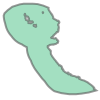

In [19]:
data.geometry[1]

In [20]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Sistemas de referencia de coordenadas

Hay muchos sistemas de referencia de coordenadas (CRS) diferentes, que se refieren a diferentes formas de indicar en qué lugar de la tierra se está refiriendo cuando da una coordenada. Los diferentes CRS utilizan diferentes modelos de la superficie terrestre, proyecciones de mapas, unidades y puntos de origen (donde 0,0 es). La discusión de los detalles está más allá del alcance de este curso.

Para los propósitos de este curso, utilizaremos principalmente los dos siguientes:

### WGS 84: https://epsg.io/4326
''
El CRS utilizado por el sistema GPS
unidades: grados
0,0 es la intersección del meridiano de Greenwich y el ecuador
código epsg: 4326
''

### Web Mercator: https://epsg.io/3857
''
El CRS utilizado por la mayoría de los mapas web, como mapas de Google, OSM, Bing, etc.
No es preciso en latitudes altas> 85 grados, <-85 grados
unidades: metros
0,0 es la intersección del ecuador y el meridiano greensich
código epsg: 3857
''

In [21]:
# area le advertirá si está intentando hacer cálculos de área en CRS geográfico
data.area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


0      19.396254
1       6.145902
2       2.697207
3      87.460621
4       0.000918
         ...    
226     5.990467
227     3.638651
228     2.849025
229     2.697207
230     2.237186
Length: 231, dtype: float64

In [ ]:
data_in_3857 = data.to_crs('epsg:3857')
data_in_3857.area

0      2.668953e+11
1      8.128889e+10
2      3.535144e+10
3      1.434295e+12
4      2.019379e+07
           ...     
226    8.857492e+10
227    5.157407e+10
228    4.009144e+10
229    3.535144e+10
230    3.025350e+10
Length: 231, dtype: float64

In [22]:
data['area'] = data.area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [23]:
data[data['area']>25]

,id_no,binomial,origin,compiler,year,citation,source,dist_comm,island,subspecies,subpop,legend,seasonal,tax_comm,rl_update,kingdom_na,phylum_nam,class_name,order_name,family_nam,genus_name,species_na,category,shape_Leng,shape_Area,ORIG_FID,geometry,area
3,183793.0,Chromis intercrusma,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,intercrusma,LC,729.012180,87.461539,1,"POLYGON ((-80.86500 -0.77894, -80.75930 -0.833...",87.460621
14,183586.0,Stegastes rectifraenum,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Stegastes,rectifraenum,LC,114.869241,40.524220,3,"POLYGON ((-114.12907 31.49156, -114.11803 31.4...",27.347730
18,183240.0,Chromis crusma,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,crusma,LC,728.345273,87.247024,5,"POLYGON ((-80.82861 -1.22984, -80.82104 -1.239...",87.246106
21,154856.0,Chromis pembae,1,None,2012,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.2,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,pembae,LC,332.714197,148.118114,6,"POLYGON ((32.56497 29.96967, 32.57328 29.96878...",113.242305
27,154915.0,Teixeirichthys jordani,1,None,2012,"Red List Index (Sampled Approach), Zoological ...",None,None,None,None,None,Extant (resident),1,None,2012.2,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Teixeirichthys,jordani,LC,498.057966,116.786519,8,"POLYGON ((121.63003 33.04249, 121.63219 33.042...",38.671198
28,154915.0,Teixeirichthys jordani,1,None,2012,"Red List Index (Sampled Approach), Zoological ...",None,None,None,None,None,Extant (resident),1,None,2012.2,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Teixeirichthys,jordani,LC,498.057966,116.786519,8,"POLYGON ((32.56219 29.97489, 32.56497 29.96967...",37.445735
41,183825.0,Microspathodon dorsalis,1,IUCN,2010,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.1,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Microspathodon,dorsalis,LC,215.424849,68.519129,10,"POLYGON ((-90.09187 13.72482, -90.09046 13.724...",28.768158
50,165910.0,Chromis cyanea,1,None,2012,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.2,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Chromis,cyanea,LC,720.329618,249.942904,11,"POLYGON ((-97.73597 24.67276, -97.73440 24.668...",249.457390
65,154812.0,Amphiprion sandaracinos,1,None,2012,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.2,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Amphiprion,sandaracinos,LC,1218.642766,494.021357,12,"POLYGON ((116.72950 -8.68616, 116.72750 -8.679...",435.709434
66,154812.0,Amphiprion sandaracinos,1,None,2012,International Union for Conservation of Nature...,None,None,None,None,None,Extant (resident),1,None,2012.2,ANIMALIA,CHORDATA,ACTINOPTERYGII,PERCIFORMES,POMACENTRIDAE,Amphiprion,sandaracinos,LC,1218.642766,494.021357,12,"POLYGON ((117.93430 -18.56846, 117.98380 -18.6...",41.816296


In [24]:
# podemos comprobar qué especies se pueden encontrar entre las latitudes 10 y 20 grados norte
data.intersects(Polygon([(-180,10),(180,10),(180,20),(-180,20)]))

0      False
1       True
2       True
3      False
4      False
       ...  
226    False
227    False
228    False
229     True
230    False
Length: 231, dtype: bool

## Ejercicios
Usando los objetos poligonales en la columna `geometría` del marco de datos:
- crea una nueva columna llamada `área` que representa las áreas de cada fila en el shapefile
- ¿Cuáles son los valores máximo, mínimo, medio y cuartiles de las áreas?
- ¿Qué fracción de las áreas son mayores de 25 grados cuadrados?
- ¿Qué especie tiene la mayor superficie total?

## Plotting (Graficar)

Geopandas proporciona una función útil `.plot ()` que crea una figura matplotlib y devuelve un objeto de ejes.

Hay un montón de bibliotecas adicionales que brindan más funciones de trazado, y exploraremos algunas de ellas aquí. No existe un conjunto "correcto" de bibliotecas para usar para SIG en Python, y depende de usted determinar cuáles encajan mejor en su flujo de trabajo.

La opción `cmap` de la función` .plot () `le permite pasar un [matplotlib colormap name] (https://matplotlib.org/gallery/color/colormap_reference.html), que son colecciones de colores que se utilizan para visualizar datos

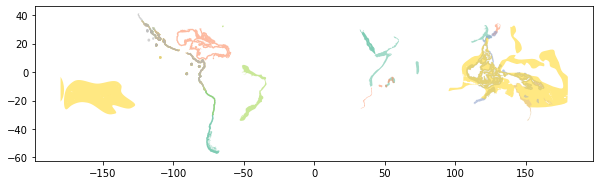

In [ ]:
# podemos usar la función de trazado de geopandas incorporada para visualizar
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Set2')

actualmente los colores se asignan arbitrariamente. Sin embargo, también podemos usar colores para codificar información.

Primero usemos colores para categorizar por estado de peligro. Para hacerlo, pasamos el argumento `column` a ` plot () `. Como referencia, también establecemos `legend = True`

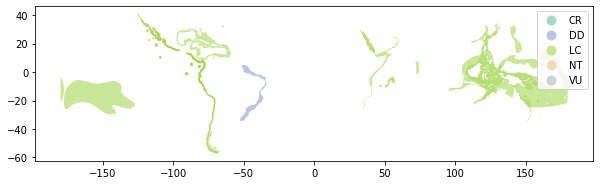

In [ ]:
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Set2', column='category', legend=True)

Otro uso común de los colores para codificar datos es representar datos numéricos en un área con colores. Esto se conoce como [Mapa de color o polígonos de color] (https://en.wikipedia.org/wiki/Choropleth_map).

Usemos **esto** para codificar las áreas de cada región.

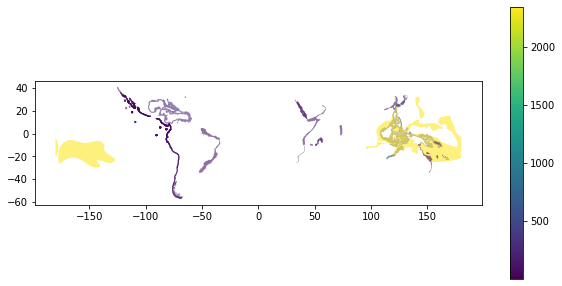

In [26]:
# luego pasa la columna del área como argumento (probar con el area obtenida en el ejercicio)
ax = data.plot(figsize=(10,5), alpha=0.6, column='shape_Area', legend=True)

La leyenda de la barra de colores es demasiado grande en relación con la figura. Tendremos que hacer algunos ajustes manuales. Hay herramientas para crear cuadrículas de ejes para barras de colores disponibles en:
https://matplotlib.org/3.1.0/tutorials/toolkits/axes_grid.html

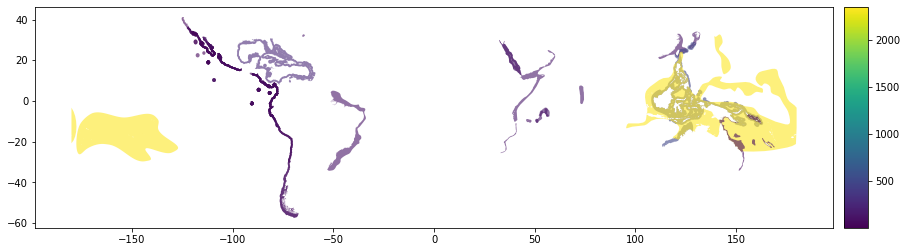

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(15,8))
divider = make_axes_locatable(ax) # lo hace para que pueda agregar a los ejes

# coloque otros ejes a la derecha, al 5% del ancho total con 0.1 puntos de relleno en el medio
cax = divider.append_axes("right", size="3%", pad=0.1) 
# tenga en cuenta que debe especificar ax y cax como argumentos para que funcione
data.plot(alpha=0.6, column='shape_Area',legend=True, ax=ax, cax=cax);

Los datos por sí mismos se ven como un montón de manchas. Pongámoslo en un mapa para el contexto

[Contextily] (https://github.com/geopandas/contextily) es una biblioteca para crear mapas base. Extrae datos de una gran cantidad de proveedores de mapas base diferentes; consulte la [documentación] (https://contextily.readthedocs.io/en/latest/) para obtener más detalles.


In [ ]:
# los datos están actualmente en WGS84 (epsg: 4326)
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

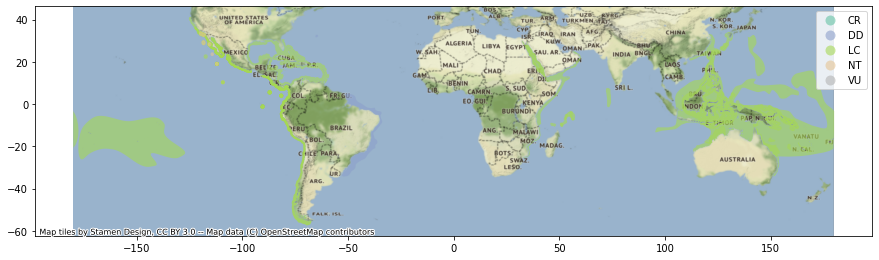

In [37]:
ax = data.plot(figsize=(15, 8), alpha=0.6, cmap='Set2', column='category', legend=True)
# ahora agregamos un mapa base. ctx encuentra un mapa base para un fondo de
# un repositorio en línea.
# Se asume que los datos están en mercator web (epsg: 3857) a menos que especifique lo contrario
ctx.add_basemap(ax, crs=data.crs)

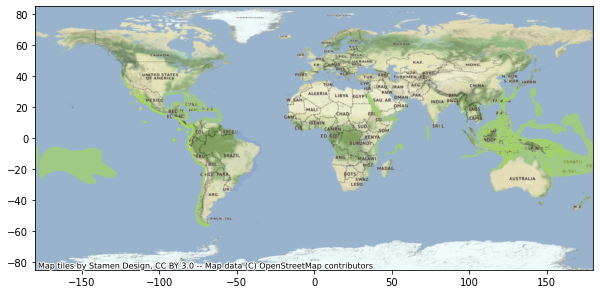

In [ ]:
# podemos establecer límites usando matplotlib
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Set2', column='category')
ax.set_xlim([-180,180])
ax.set_ylim([-85,85])
ctx.add_basemap(ax, crs=data.crs)

* Podemos * usar diferentes estilos de fondo:
![tile styles](https://contextily.readthedocs.io/en/latest/_images/tiles.png).

Tenga en cuenta que algunos estilos solo contienen etiquetas o líneas.

In [38]:
# para ver todos los diferentes proveedores, marque:
ctx.providers

{'AzureMaps': {'MicrosoftBaseDarkGrey': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'html_attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'language': 'en-US',
   'name': 'AzureMaps.MicrosoftBaseDarkGrey',
   'subscriptionKey': '<insert your subscription key here>',
   'url': 'https://atlas.microsoft.com/map/tile?api-version={apiVersion}&tilesetId={variant}&x={x}&y={y}&zoom={z}&language={language}&subscription-key={subscriptionKey}',
   'variant': 'microsoft.base.darkgrey'},
  'MicrosoftBaseHybridRoad': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'html_attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'language': 'en-US',
   'name': 'AzureMaps.MicrosoftBaseHybridRoad',
   'subscriptionKey': '<insert your subscription key here>',
   'url': 'https://atlas.microsoft.com/map/tile?api-version={apiVersion}&tilesetId={variant}&x={x}&y={y}&zoom={z}&language={language}&subscription-key={subscriptionKey}',
   'variant': 'microsoft.base.hybrid.road'},
  'MicrosoftBaseRoad': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'html_attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'language': 'en-US',
   'name': 'AzureMaps.MicrosoftBaseRoad',
   'subscriptionKey': '<insert your subscription key here>',
   'url': 'https://atlas.microsoft.com/map/tile?api-version={apiVersion}&tilesetId={variant}&x={x}&y={y}&zoom={z}&language={language}&subscription-key={subscriptionKey}',
   'variant': 'microsoft.base.road'},
  'MicrosoftImagery': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'html_attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'language': 'en-US',
   'name': 'AzureMaps.MicrosoftImagery',
   'subscriptionKey': '<insert your subscription key here>',
   'url': 'https://atlas.microsoft.com/map/tile?api-version={apiVersion}&tilesetId={variant}&x={x}&y={y}&zoom={z}&language={language}&subscription-key={subscriptionKey}',
   'variant': 'microsoft.imagery'},
  'MicrosoftTerraMain': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'html_attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview for details.',
   'language': 'en-US',
   'name': 'AzureMaps.MicrosoftTerraMain',
   'subscriptionKey': '<insert your subscription key here>',
   'url': 'https://atlas.microsoft.com/map/tile?api-version={apiVersion}&tilesetId={variant}&x={x}&y={y}&zoom={z}&language={language}&subscription-key={subscriptionKey}',
   'variant': 'microsoft.terra.main'},
  'MicrosoftWeatherInfraredMain': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview#uri-parameters for details.',
   'html_attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview#uri-parameters for details.',
   'language': 'en-US',
   'name': 'AzureMaps.MicrosoftWeatherInfraredMain',
   'subscriptionKey': '<insert your subscription key here>',
   'timeStamp': '2021-05-08T09:03:00Z',
   'url': 'https://atlas.microsoft.com/map/tile?api-version={apiVersion}&tilesetId={variant}&x={x}&y={y}&zoom={z}&timeStamp={timeStamp}&language={language}&subscription-key={subscriptionKey}',
   'variant': 'microsoft.weather.infrared.main'},
  'MicrosoftWeatherRadarMain': {'apiVersion': '2.0',
   'attribution': 'See https://docs.microsoft.com/en-US/rest/api/maps/renderv2/getmaptilepreview#uri-parameters for de

Se pueden ver vistas previas de los diferentes estilos de mapas base en: http://leaflet-extras.github.io/leaflet-providers/preview/

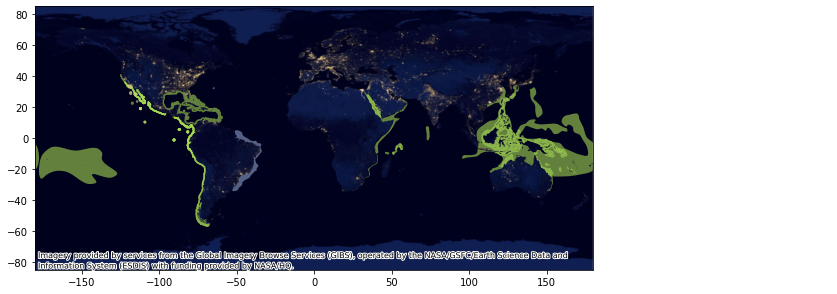

In [40]:
ax = data.plot(figsize=(10,5), alpha=0.6, cmap='Set2', column='category')
ax.set_xlim([-180,180])
ax.set_ylim([-85,85])
# para especificar el tipo de mapa base, especifique el argumento fuente
# la sintaxis es ctx.providers.{provider name}.{provider style}
#ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.Stamen.Watercolor)
# puede agregar etiquetas independientemente del fondo
ctx.add_basemap(ax, crs=data.crs, source=ctx.providers.NASAGIBS.ViirsEarthAtNight2012)

In [41]:
# podemos descargar mosaicos de fondo como imágenes para una carga más rápida (no es necesario volver a descargar)
# usemos los límites de una de las ubicaciones de los peces como ejemplo
w,s,e,n = data.loc[25,'geometry'].bounds
data.loc[10,'geometry'].bounds

(-79.56737515199995, 8.442261236000036, -78.48675787199994, 9.030436516000066)

la función limits2img toma coordenadas y [nivel de zoom](https://wiki.openstreetmap.org/wiki/Zoom_levels) y descarga los mosaicos correspondientes del mapa como imágenes

[(2498442.0929655447, 2884399.3464440187),
 (-12544723.739110544, -12090944.453255981)]

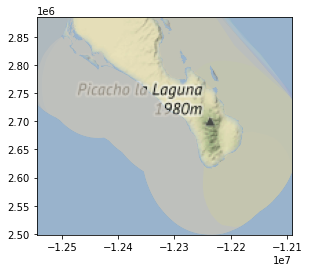

In [42]:
img, ext = ctx.bounds2img(w, s, e, n, 6, ll=True) #ll significa que las coordenadas están en lat-lon
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img, extent=ext)
# limits2img devuelve cosas en epsg: 3857, por lo que necesitamos trazar los datos en el mismo crs
data.to_crs(epsg=3857).plot(ax=ax, cmap='Set3', alpha=0.1)
ax_bounds = data.to_crs(epsg=3857).loc[25,'geometry'].bounds
ax.set(xlim=[ax_bounds[0],ax_bounds[2]],ylim=[ax_bounds[1],ax_bounds[3]])


## Escribiendo en un shapefile

Primero crearemos un directorio para enviar datos. Usamos el comando `mkdir` que crea una carpeta vacía. La opción `-p` la omitirá si el directorio ya existe

In [43]:
!mkdir output_data -p

In [44]:
# escribamos las primeras 50 filas del shapefile en un nuevo archivo
outfp = "output_data/DAMSELFISH_distributions_SELECTION.shp"

# Seleccione las primeras 50 filas
selection = data[0:50]

# Escriba esas filas en un nuevo Shapefile (el formato de archivo de salida predeterminado es Shapefile)
selection.to_file(outfp)

## Conversión de formas a GeoDataFrames
Puede utilizar objetos geométricos Shapely para crear un GeoDataFrame desde cero.

In [45]:
# Crea un GeoDataFrame de geopandas vacío
newdata = gpd.GeoDataFrame()

# agregar una columna de geometría (necesaria para el shapefile)
newdata['geometry'] = None

# Veamos qué tenemos en este momento
print(newdata)

Empty GeoDataFrame
Columns: [geometry]
Index: []


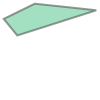

In [46]:
# Coordenadas del campus principal del MIT en grados decimales
coordinates = [(-71.092562, 42.357602), ( -71.080155, 42.361553), ( -71.089817, 42.362584), (-71.094688, 42.360198)]

# Crea un polígono Shapely a partir de la lista de tuplas de coordenadas
poly = Polygon(coordinates)

# Veamos que tenemos
poly

¡Punto de control rápido! Encuentra las coordenadas de las esquinas de un lugar que tenga un significado significativo para ti. Al igual que hicimos anteriormente, crea un polígono Shapely a partir de la lista de tuplas de coordenadas de las esquinas de tu punto de referencia personal.
¡Muéstralo! Puede ser tan grande como quieras. Si lo desea, comparta con la clase el lugar y por qué es importante para usted.

In [47]:
# Coordenadas del lugar de importancia en grados decimales
coordinates_personal =[]

# Crea un polígono Shapely a partir de la lista de tuplas de coordenadas
poly_personal =Polygon

#Muestre el lugar y comparta su significado si lo desea

In [48]:
# Inserte el polígono en la columna 'geometry' en el índice 0
newdata.loc[0, 'geometry'] = poly
newdata

,geometry
0,"POLYGON ((-71.09256 42.35760, -71.08016 42.361..."


In [49]:
newdata.loc[0, 'location'] = 'MIT main campus'
newdata

,geometry,location
0,"POLYGON ((-71.09256 42.35760, -71.08016 42.361...",MIT main campus


Antes de exportar los datos es necesario configurar el sistema de referencia de coordenadas (proyección) para el GeoDataFrame.

Configuraremos el crs usando una función de `fiona`, otra biblioteca GIS integrada con geopandas.

In [50]:
newdata.crs

In [51]:
# Establezca el sistema de coordenadas del GeoDataFrame en WGS84 (es decir, código epsg 4326)
newdata = newdata.set_crs('epsg:4326')

# Veamos cómo se ve la definición de crs
newdata.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [52]:
outfp = "output_data/MIT_campus.shp"

# Escribe la data en un Shapefile
newdata.to_file(outfp)

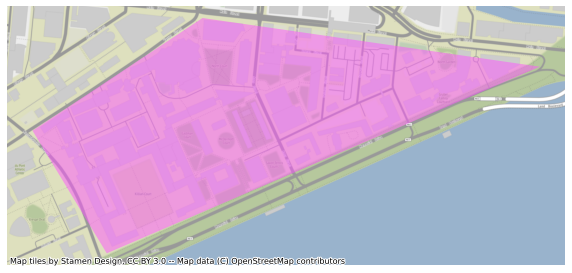

In [53]:
# Vamos a mapear
ax = newdata.to_crs(epsg=3857).plot(figsize=(10,5),alpha = 0.5, color='#FF55FF')
ctx.add_basemap(ax)
ax.set_axis_off() # borra los ejes x-y

# Ejercicio
Encuentre un conjunto de datos GIS interesante y:
- visualizar algunos datos sin procesar
- haga una pregunta de análisis interesante al respecto:
   - intersecciones, tamaños, cantidades
   - relaciones
   - p.ej. ¿Qué latitudes contienen las especies más amenazadas? ¿Qué países tienen más puertos por km de costa?
- Visualiza algunos de tus análisis

Como es habitual, pediremos a algunos voluntarios que presenten sus resultados.

A continuación, se muestran algunos recursos para buscar conjuntos de datos SIG:
- Cambridge, MA Datos de SIG: http://cambridgegis.github.io/gisdata.html
- Datos GIS gratuitos: https://freegisdata.rtwilson.com/
- Data.gov: https://www.data.gov/

Una parte importante de la responsabilidad de los ingenieros de GIS durante la pandemia es visualizar la propagación y la intensidad de los casos durante la pandemia. Usando conjuntos de datos de las siguientes fuentes:


* Visualice datos sin procesar recopilados de fuentes de todo el mundo sobre el estado de la pandemia
* Explore las conexiones entre varios factores y presente una hipótesis para su investigación. Algunas ideas podrían ser conectar datos de COVID en diferentes condados con datos de socioeconomía, edad o arquitectura de edificios. Recuerde, los datos de mapeo hablan más fuerte que los gráficos o los conjuntos de datos.
* Presente sus hallazgos al resto de la clase y proponga una posible solución al problema o la conexión que exploró.

Conjuntos de datos COVID-19:
* Conjunto de datos COVID-19 (Kaggle): www.kaggle.com/imdevskp/corona-virus-report
* Conjunto de datos del New York Times: https://github.com/nytimes/covid-19-data
* Conjunto de datos de JHU: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
* Siéntase libre de explorar más conjuntos de datos o conjuntos de datos específicos del área que describen otras condiciones. Estas son solo sugerencias.

Para hacer sus conexiones de investigación, asegúrese de explorar la población y los conjuntos de datos demográficos de diferentes condados del país. ¡Sea creativo con su investigación!

Trace una forma de su ciudad natal en el mapa. De manera similar a como mapeamos las coordenadas del campus del MIT en un mapa, mapee las coordenadas de su ciudad natal en un mapa. No tiene que ser exacto, solo toma un par de coordenadas aproximadas y visualiza tu lugar en el mapa. Los TA intentarán mapear estas formas en un mapa completo para que podamos tener una idea de dónde son todos y visualizar cuán geográficamente diversa es nuestra clase.